In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import glob
from astropy.io import fits
import scipy
import pickle
import scipy.interpolate as interp
from matplotlib.colors import SymLogNorm, LogNorm

from ctisim import ITL_AMP_GEOM, FloatingOutputAmplifier, SegmentSimulator
from ctisim import LinearTrap, SplineTrap
from ctisim.fitting import OverscanFitting, BiasDriftSimpleModel, FixedLossSimpleModel
from ctisim.matrix import electronics_operator, trap_operator

oscan_results_file = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6790D_linearity/R02/S02/R02_S02_overscan_results.fits'
amp_geom = ITL_AMP_GEOM
ncols = amp_geom.nx + amp_geom.prescan_width
read_noise = 7.0

## Overscan Fitting

In [2]:
## Overscan fitting parameters
start = 4
stop = 20
min_signal = 50000.
max_signal = 150000.

output_amplifiers = {}

oscan_data = {}

with fits.open(oscan_results_file) as oscan_results:
    for amp in range(1, 17):
        
        signals_all = oscan_results[amp].data['FLATFIELD_SIGNAL']
        data_all = oscan_results[amp].data['COLUMN_MEAN'][:, start:stop+1]
        oscan_data[amp] = (signals_all, oscan_results[amp].data['COLUMN_MEAN'])
        indices = (signals_all < max_signal)*(signals_all>min_signal)
        
        signals = signals_all[indices]
        data = data_all[indices]
        
        params0 = [-7., 2.0, 2.5]
        constraints = [(-7., -7.), (0, 10.), (0.01, 4.0)]
        
        fitting_task = OverscanFitting(params0, constraints, BiasDriftSimpleModel,
                                       start=start, stop=stop)
        fit_results = scipy.optimize.minimize(fitting_task.rms_error, params0,
                                              args=(signals, data, read_noise/np.sqrt(2000.), ncols),
                                              bounds=constraints, method='SLSQP')
        scale = fit_results.x[1]/10000.
        decay_time = fit_results.x[2]
        print(scale, decay_time)
        
        output_amplifiers[amp] = FloatingOutputAmplifier(1.0, scale, decay_time)

0.0001071034420169422 3.390011383920389
9.95070517042739e-05 3.3215321629699024
8.224375596271322e-05 3.5838845168668816
8.58898821411689e-05 3.535730470922777
9.09112481342315e-05 3.4803177767635436
8.949081232428626e-05 3.523639645055344
9.275191717244344e-05 3.4092907998557176
5.178581271211893e-05 3.470069771293162
0.0001628271971091916 2.5119923325461078
0.00010762198480871139 3.209062189594855
8.15781573258278e-05 3.628339316553812
8.41686889065576e-05 3.446061333657486
8.218042281425437e-05 3.501629233186046
0.00010523774348302324 3.223388676309734
9.619983221359868e-05 3.367967998357534
8.845043786720957e-05 3.568932790817318


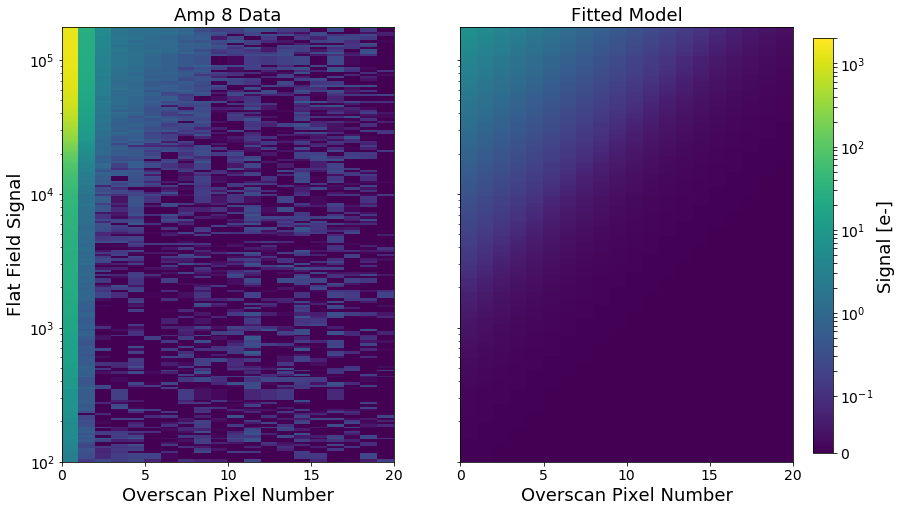

In [3]:
amp = 8
signals = oscan_data[amp][0]
imarr = np.zeros((signals.shape[0], ITL_AMP_GEOM.nx))

## Simulate ramp readout
ramp = SegmentSimulator(imarr, ITL_AMP_GEOM.prescan_width, output_amplifiers[amp])
ramp.ramp_exp(signals)
model_results = ramp.readout(serial_overscan_width=ITL_AMP_GEOM.serial_overscan_width,
                             parallel_overscan_width=0)

y=signals
x=np.arange(21)
X,Y=np.meshgrid(x, y)

vmax = 2000

fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=True)
im0 = axes[0].pcolor(X, Y, oscan_data[amp][1][:, 1:22], 
                     norm=SymLogNorm(0.1), vmin=0., vmax=vmax)
im1 = axes[1].pcolor(X, Y, model_results[:, ncols:ncols+21], 
                     norm=SymLogNorm(0.1), vmin=0., vmax=vmax)
axes[0].set_yscale('log')
axes[0].set_ylabel('Flat Field Signal', fontsize=18)
axes[0].set_xlabel('Overscan Pixel Number', fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].set_title('Amp {0} Data'.format(amp), fontsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].set_xlabel('Overscan Pixel Number', fontsize=18)
axes[1].set_title('Fitted Model', fontsize=18)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.14, 0.02, 0.72])
cbar= fig.colorbar(im0, cax=cbar_ax)
cbar.set_label('Signal [e-]', fontsize=18)
cbar.ax.tick_params(labelsize=14)

## CTI Low Signal Fitting

In [4]:
## CTI fitting parameters
start = 1
stop = 3
min_signal = 0.0
max_signal = 10000.

cti_results = {}
with fits.open(oscan_results_file) as oscan_results:
    for amp in range(1, 17):
        
        signals_all = oscan_results[amp].data['FLATFIELD_SIGNAL']
        data_all = oscan_results[amp].data['COLUMN_MEAN'][:, start:stop+1]
        indices = (signals_all < max_signal)*(signals_all>min_signal)
        
        signals = signals_all[indices]
        data = data_all[indices]
        
        params0 = [-6., 1.0, 0.4, 0.08]
        constraints = [(-6.5, -5.8), (0, 10.), (0.1, 0.6), (0.01, 1.0)]
        
        fitting_task = OverscanFitting(params0, constraints, FixedLossSimpleModel,
                                       start=start, stop=stop)
        fit_results = scipy.optimize.minimize(fitting_task.rms_error, params0,
                                              args=(signals, data, read_noise/np.sqrt(2000.), ncols),
                                              bounds=constraints, method='SLSQP')
        cti_results[amp] = 10**fit_results.x[0]
        if fit_results.x[1] > 1.:
            print(amp)

8
9


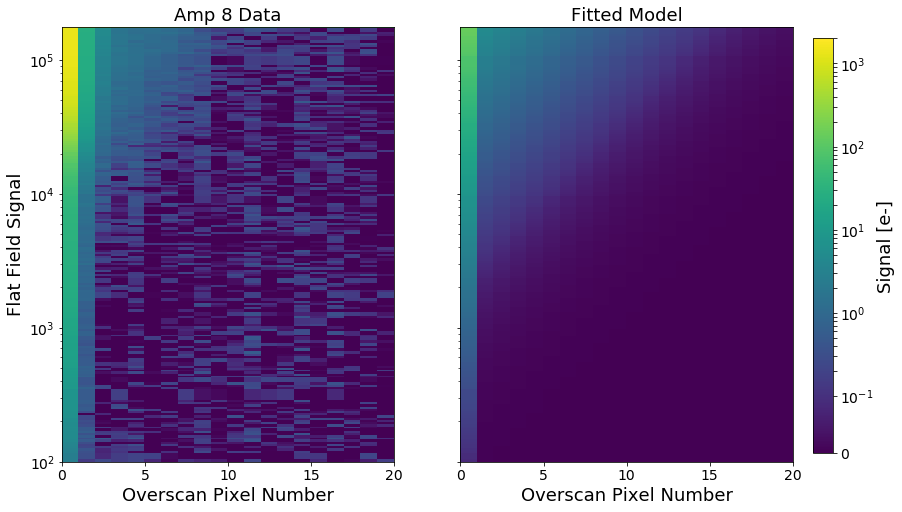

In [5]:
amp = 8
signals = oscan_data[amp][0]
imarr = np.zeros((signals.shape[0], ITL_AMP_GEOM.nx))

## Simulate ramp readout
ramp = SegmentSimulator(imarr, ITL_AMP_GEOM.prescan_width, output_amplifiers[amp], cti=cti_results[amp])
ramp.ramp_exp(signals)
model_results = ramp.readout(serial_overscan_width=ITL_AMP_GEOM.serial_overscan_width,
                             parallel_overscan_width=0)

y=signals
x=np.arange(21)
X,Y=np.meshgrid(x, y)

fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=True)
im0 = axes[0].pcolor(X, Y, oscan_data[amp][1][:, 1:22], 
                     norm=SymLogNorm(0.1), vmin=0, vmax=vmax)
im1 = axes[1].pcolor(X, Y, model_results[:, ncols:ncols+21], 
                     norm=SymLogNorm(0.1), vmin=0, vmax=vmax)
axes[0].set_yscale('log')
axes[0].set_ylabel('Flat Field Signal', fontsize=18)
axes[0].set_xlabel('Overscan Pixel Number', fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].set_title('Amp {0} Data'.format(amp), fontsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].set_xlabel('Overscan Pixel Number', fontsize=18)
axes[1].set_title('Fitted Model', fontsize=18)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.14, 0.02, 0.72])
cbar= fig.colorbar(im0, cax=cbar_ax)
cbar.set_label('Signal [e-]', fontsize=18)
cbar.ax.tick_params(labelsize=14) 

## Residual Trapping

In [17]:
start = 1
stop = 3

spltraps = {}
with fits.open(oscan_results_file) as oscan_results:
    for amp in range(1, 17):
        
        signals_all = oscan_results[amp].data['FLATFIELD_SIGNAL']
        data_all = oscan_results[amp].data['COLUMN_MEAN'][:, start:stop+1]
        
        indices = signals_all < 150000.
        
        signals = signals_all[indices]
        data = data_all[indices]

        ## Simulate ramp readout
        imarr = np.zeros((signals.shape[0], ITL_AMP_GEOM.nx))
        ramp = SegmentSimulator(imarr, ITL_AMP_GEOM.prescan_width, output_amplifiers[amp], cti=cti_results[amp])
        ramp.ramp_exp(signals)
        model_results = ramp.readout(serial_overscan_width=ITL_AMP_GEOM.serial_overscan_width,
                                     parallel_overscan_width=0)
        model = model_results[:, ncols:ncols+stop-start+1]
        
        x = signals
        y = np.sum(data-model, axis=1)
        # Pad left with ramp
        y = np.pad(y, (10, 0), 'linear_ramp', end_values=(0, 0))
        x = np.pad(x, (10, 0), 'linear_ramp', end_values=(0, 0))

        # Pad right with constant
        y = np.pad(y, (1, 1), 'constant', constant_values=(0, np.max(y)))
        x = np.pad(x, (1, 1), 'constant', constant_values=(-1, 200000.))
        
        f = interp.interp1d(x, y)
        spltraps[amp] = SplineTrap(f, 0.4, 1)

Text(0.5, 1.0, 'Overscan Pixel Residual Signal')

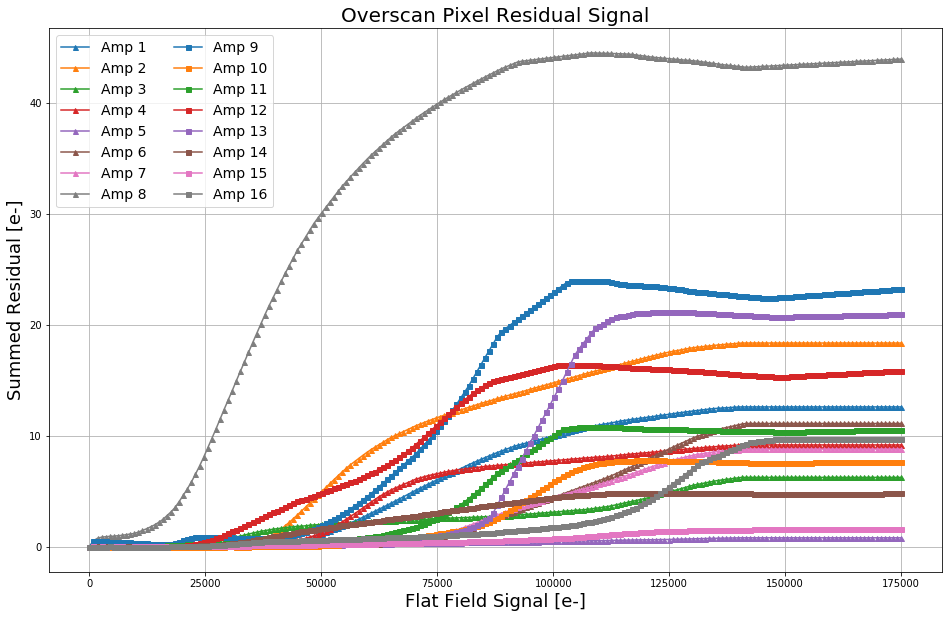

In [18]:
signals = np.linspace(2, 175000., 200)
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
cmap = plt.get_cmap("tab10")

for amp in range(1, 17):
    
    if amp > 8: marker='s'
    else: marker = '^'
    ax.plot(signals, spltraps[amp].f(signals)/30., label='Amp {0}'.format(amp),
            color=cmap((amp-1)%8), marker=marker, markersize=5)
    
ax.legend(ncol=2, fontsize=14, loc='upper left')
    
ax.grid(which='both', axis='both')
ax.set_ylabel('Summed Residual [e-]', fontsize=18)
ax.set_xlabel('Flat Field Signal [e-]', fontsize=18)
ax.set_title('Overscan Pixel Residual Signal', fontsize=20)

In [27]:
for amp in range(1, 17):
    pickle.dump(spltraps[amp], open('test_amp{0}_traps.pkl', 'wb'))

## Correction

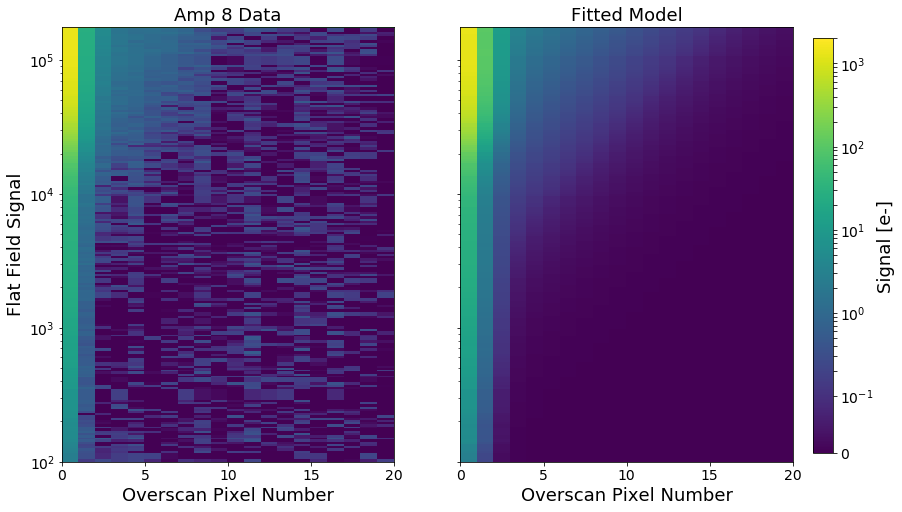

In [19]:
amp = 8
signals = oscan_data[amp][0]
imarr = np.zeros((signals.shape[0], ITL_AMP_GEOM.nx))

## Simulate ramp readout
ramp = SegmentSimulator(imarr, ITL_AMP_GEOM.prescan_width, output_amplifiers[amp], cti=cti_results[amp],
                        traps=spltraps[amp])
ramp.ramp_exp(signals)
model_results = ramp.readout(serial_overscan_width=ITL_AMP_GEOM.serial_overscan_width,
                             parallel_overscan_width=0)

y=signals
x=np.arange(21)
X,Y=np.meshgrid(x, y)

fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=True)
im0 = axes[0].pcolor(X, Y, oscan_data[amp][1][:, 1:22], 
                     norm=SymLogNorm(0.1), vmin=0, vmax=vmax)
im1 = axes[1].pcolor(X, Y, model_results[:, ncols:ncols+21], 
                     norm=SymLogNorm(0.1), vmin=0, vmax=vmax)
axes[0].set_yscale('log')
axes[0].set_ylabel('Flat Field Signal', fontsize=18)
axes[0].set_xlabel('Overscan Pixel Number', fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].set_title('Amp {0} Data'.format(amp), fontsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].set_xlabel('Overscan Pixel Number', fontsize=18)
axes[1].set_title('Fitted Model', fontsize=18)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.14, 0.02, 0.72])
cbar= fig.colorbar(im0, cax=cbar_ax)
cbar.set_label('Signal [e-]', fontsize=18)
cbar.ax.tick_params(labelsize=14) 

In [22]:
x =oscan_data[amp][1][:, 1:22]-model_results[:, ncols:ncols+21]

In [24]:
np.max(x[:, :5])

3430.920535626511